# Global Financial Market Data Harmonization Project

## Problem Statement
Despite post-2008 financial crisis reforms in derivatives trading and reporting, financial regulators face significant challenges in obtaining a comprehensive view of market activity due to:
- Inconsistent data formats across different jurisdictions
- Varying reporting standards between exchanges
- Multiple currency denominations
- Lack of standardized data elements
- Difficulties in cross-border data sharing and analysis

## Objective
Develop a machine learning solution to:
1. Harmonize financial market data across different exchanges
2. Create standardized reporting formats
3. Enable real-time risk assessment across global markets
4. Facilitate regulatory oversight through unified data analysis



1. RSI → Momentum and Reversal Points
2. MACD → Trend Changes and Strength
3. Volume → Confirmation of Price Moves
4. Volatility → Risk Levels
5. Bollinger Bands → Price Channels and Extremes

In [ ]:
!pip install keras tensorflow --upgrade

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

Starting analysis of /content/indexProcessed.csv
Loading data...
Creating features...
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - loss: 34.3915 - mae: 2.6964 - val_loss: 23.3725 - val_mae: 2.2613
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step


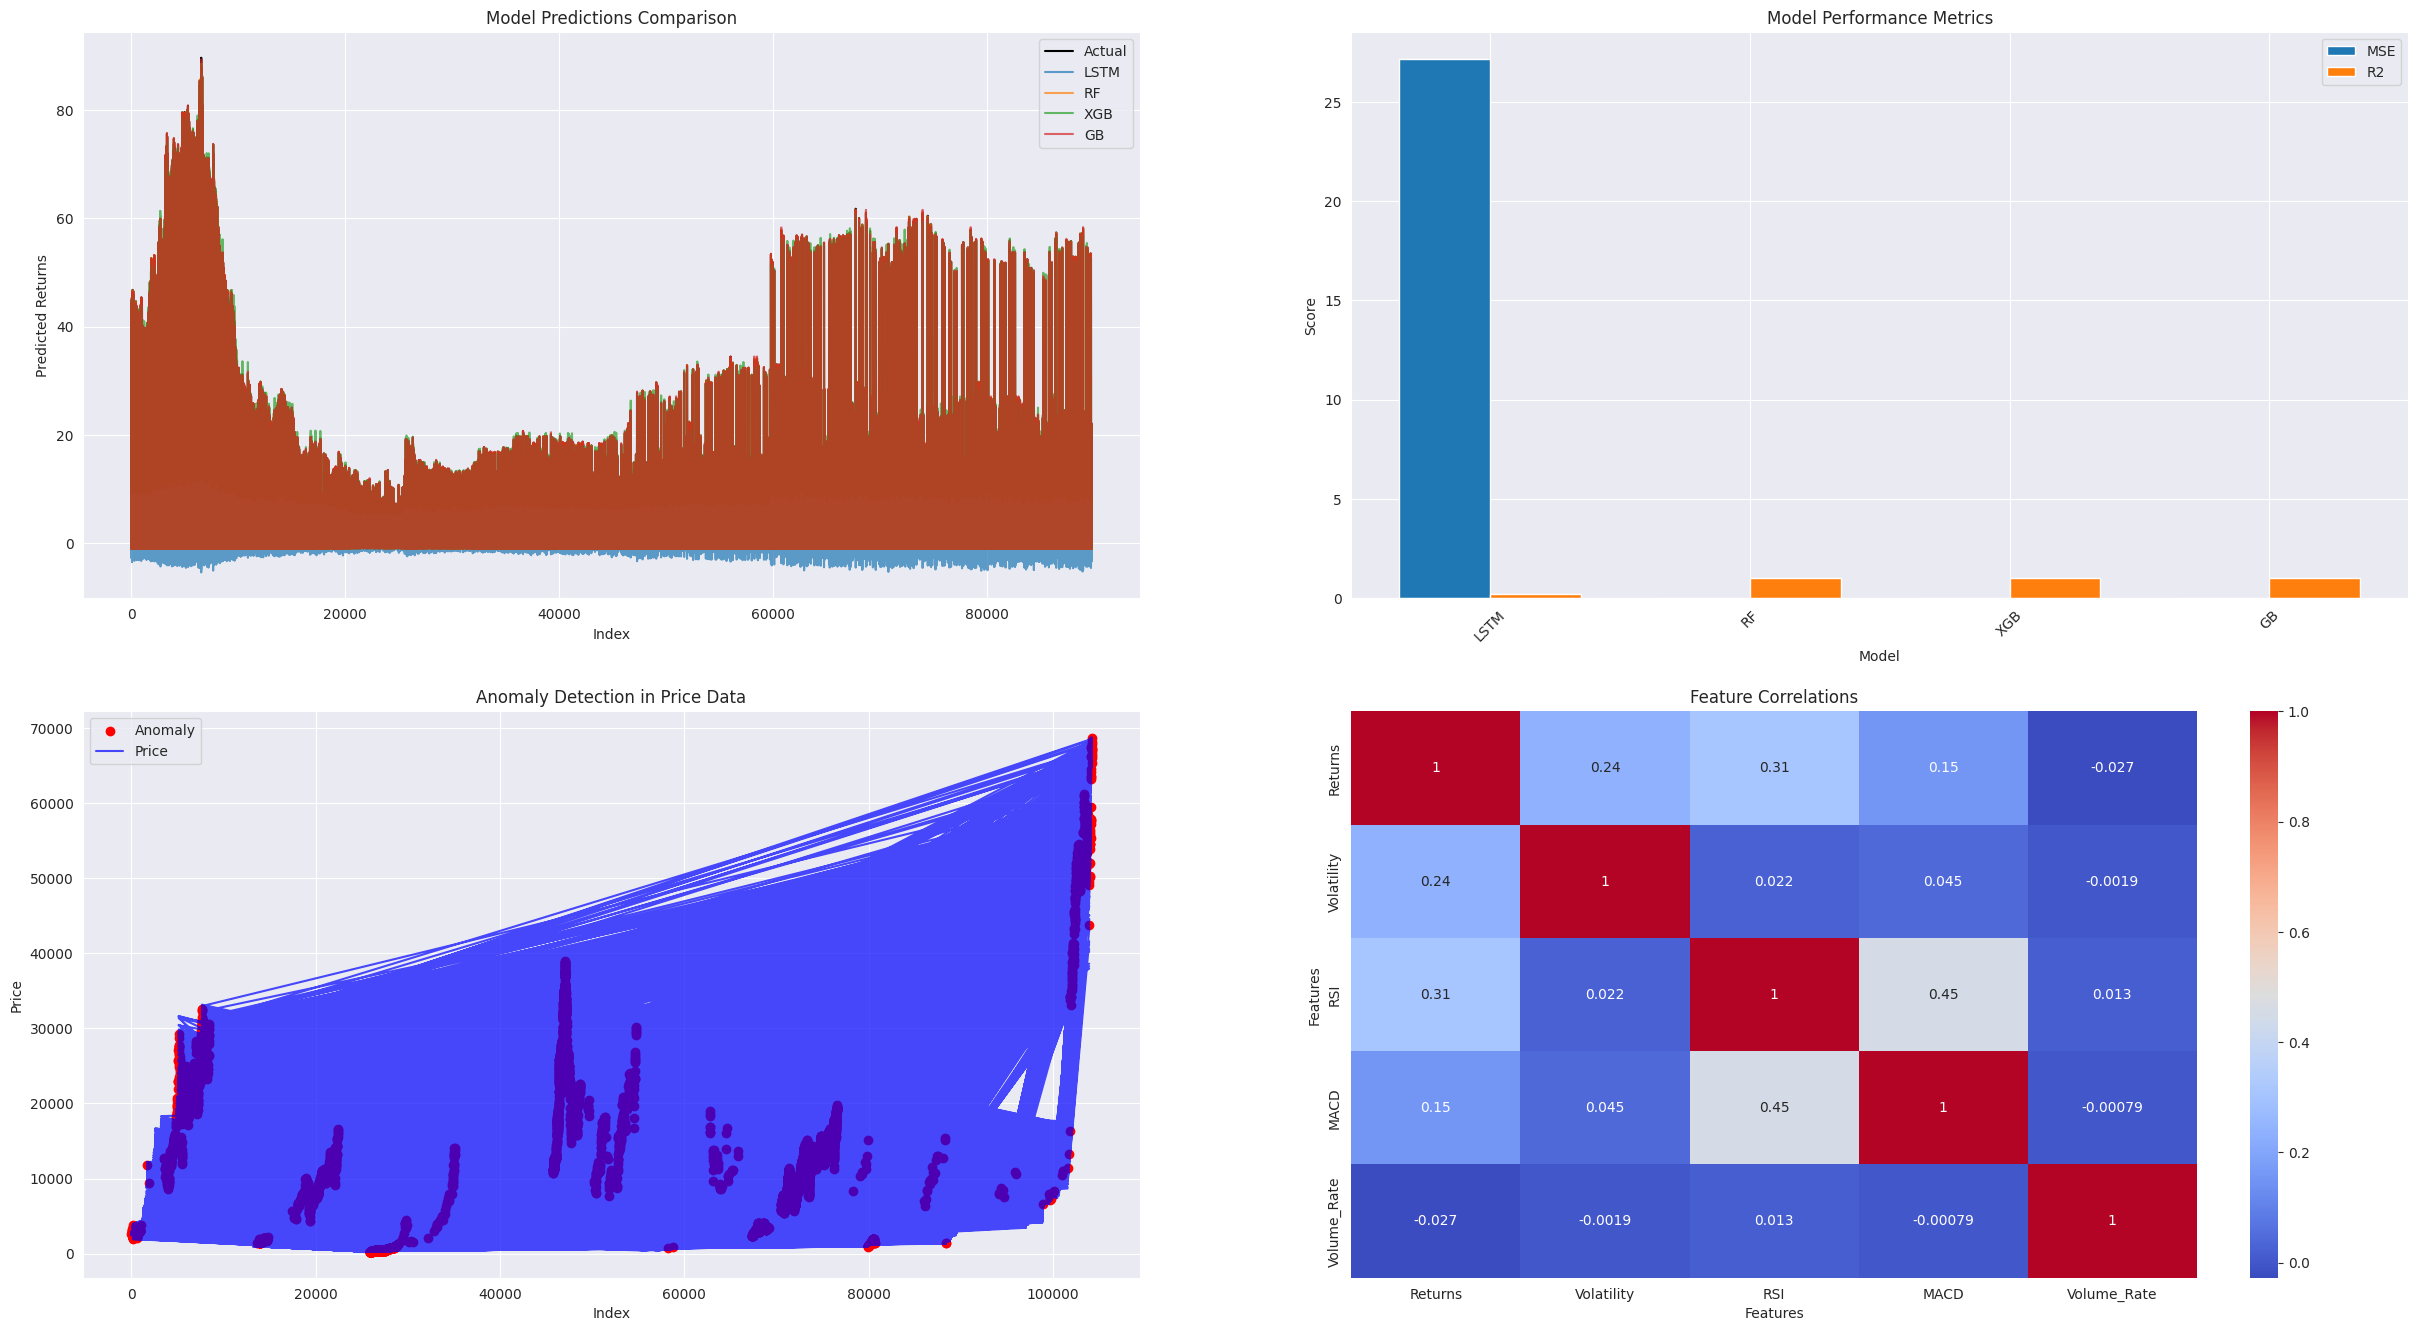

In [10]:
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# ML models and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

class MarketAnalyzer:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.df = None
        self.models = {}
        self.predictions = {}
        self.scaler = MinMaxScaler()

    def load_data(self):
        """Load and prepare CSV data"""
        self.df = pd.read_csv(self.csv_path)
        # Convert Date column and handle time series
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df = self.df.sort_values('Date')

    def create_features(self):
        """Create technical indicators for analysis"""
        df = self.df.copy()
        # Feature engineering: Includes various technical indicators
        df['Returns'] = df['Close'].pct_change()  # Percentage change in closing price
        df['Log_Returns'] = np.log(df['Close']/df['Close'].shift(1))  # Logarithmic returns
        df['MA5'] = df['Close'].rolling(window=5).mean()  # 5-period Moving Average
        df['MA20'] = df['Close'].rolling(window=20).mean()  # 20-period Moving Average
        df['MA50'] = df['Close'].rolling(window=50).mean()  # 50-period Moving Average
        df['Volatility'] = df['Returns'].rolling(window=20).std()  # Volatility (rolling std dev of returns)

        # RSI Calculation (Relative Strength Index)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # MACD Calculation (Moving Average Convergence Divergence)
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Bollinger Bands Calculation
        df['BB_middle'] = df['Close'].rolling(window=20).mean()  # Middle band (MA20)
        df['BB_upper'] = df['BB_middle'] + 2*df['Close'].rolling(window=20).std()  # Upper band
        df['BB_lower'] = df['BB_middle'] - 2*df['Close'].rolling(window=20).std()  # Lower band

        # Volume features
        df['Volume_MA'] = df['Volume'].rolling(window=20).mean()  # Moving average of volume
        df['Volume_Rate'] = df['Volume'] / df['Volume_MA']  # Volume rate

        df = df.dropna()  # Drop rows with NaN values after rolling features
        self.df = df

    def prepare_data(self, sequence_length=50):
        """Prepare data for both LSTM and traditional ML models"""
        # Features used for both LSTM and traditional models
        features = ['Returns', 'Log_Returns', 'MA5', 'MA20', 'MA50',
                    'Volatility', 'RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volume_Rate']

        # Scale the data using MinMaxScaler for consistency
        scaled_data = self.scaler.fit_transform(self.df[features])

        # Prepare sequences for LSTM model (predicting 'Returns')
        # Input: Previous 50 time steps' data, Output: Predicting the 'Returns' on the next step
        X_lstm, y_lstm = [], []
        for i in range(len(scaled_data) - sequence_length):
            X_lstm.append(scaled_data[i:i+sequence_length])  # Sequence of features as input
            y_lstm.append(self.df['Returns'].values[i + sequence_length])  # Next step's 'Returns' as output
        X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

        # Prepare flattened data for traditional ML models (predicting 'Returns')
        # Input: Same features used in LSTM, Output: 'Returns' for prediction
        X_trad = self.df[features].values[sequence_length:]  # Skip first `sequence_length` rows
        y_trad = self.df['Returns'].values[sequence_length:]

        return X_lstm, y_lstm, X_trad, y_trad

    def build_lstm_model(self, input_shape):
        """Build LSTM model"""
        model = Sequential([
            LSTM(50, input_shape=input_shape, return_sequences=False),
            Dense(1)  # Output layer with 1 node to predict the 'Returns' value
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train_models(self, X_lstm, y_lstm, X_trad, y_trad):
        """Train both LSTM and traditional ML models"""
        # Train LSTM model on sequence data
        lstm_model = self.build_lstm_model(X_lstm.shape[1:])
        lstm_model.fit(X_lstm, y_lstm, epochs=1, batch_size=32, validation_split=0.1)
        self.models['LSTM'] = lstm_model
        self.predictions['LSTM'] = lstm_model.predict(X_lstm)

        # Train traditional ML models (Random Forest, XGBoost, SVR, Gradient Boosting) on flat data
        # All models are predicting 'Returns'

        # RandomForestRegressor (predicting 'Returns')
        rf_model = RandomForestRegressor(n_estimators=100)
        rf_model.fit(X_trad, y_trad)
        self.models['RF'] = rf_model
        self.predictions['RF'] = rf_model.predict(X_trad)

        # XGBoostRegressor (predicting 'Returns')
        xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
        xgb_model.fit(X_trad, y_trad)
        self.models['XGB'] = xgb_model
        self.predictions['XGB'] = xgb_model.predict(X_trad)

        # Support Vector Regressor (SVR) (predicting 'Returns')
        # svr_model = SVR(kernel='rbf')
        # svr_model.fit(X_trad, y_trad)
        # self.models['SVR'] = svr_model
        # self.predictions['SVR'] = svr_model.predict(X_trad)

        # GradientBoostingRegressor (predicting 'Returns')
        gb_model = GradientBoostingRegressor(n_estimators=100)
        gb_model.fit(X_trad, y_trad)
        self.models['GB'] = gb_model
        self.predictions['GB'] = gb_model.predict(X_trad)

    def detect_anomalies(self):
        """Detect market anomalies"""
        # Using 'Returns', 'Volatility', and 'Volume_Rate' to detect anomalies
        features = ['Returns', 'Volatility', 'Volume_Rate']
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        return iso_forest.fit_predict(self.df[features]) == -1


    def detect_anomalies_for_model(self, model):
        """
        Detect anomalies for each model by comparing predictions with actual values.
        This method should output a boolean array indicating anomalies.
        """
        # Example: calculate anomaly as predictions that are outside a certain threshold
        features = ['Returns', 'Volatility', 'Volume_Rate']
        predictions = model.predict(self.df[features].values)
        threshold = np.std(predictions)  # For example, using standard deviation as threshold
        anomalies = abs(predictions - self.df['Returns'].values) > threshold
        return anomalies

    def plot_results(self, y_test, anomalies, history):
        """Create visualizations with added details for x/y axis, and combined anomaly detection dashboard"""
        sns.set_style('darkgrid')
        fig = plt.figure(figsize=(30, 25))

        # Model predictions with axis labels
        ax1 = plt.subplot(321)
        ax1.plot(y_test, label='Actual', color='black')
        for name, pred in self.predictions.items():
            ax1.plot(pred, label=name, alpha=0.7)
        ax1.set_title('Model Predictions Comparison')
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Predicted Returns')
        ax1.legend()

        # Performance metrics with axis labels
        ax2 = plt.subplot(322)
        metrics = {name: {
            'MSE': mean_squared_error(y_test, pred),
            'R2': r2_score(y_test, pred)
        } for name, pred in self.predictions.items()}

        model_names = list(metrics.keys())
        mse_scores = [m['MSE'] for m in metrics.values()]
        r2_scores = [m['R2'] for m in metrics.values()]

        x = np.arange(len(model_names))
        width = 0.35
        ax2.bar(x - width/2, mse_scores, width, label='MSE')
        ax2.bar(x + width/2, r2_scores, width, label='R2')
        ax2.set_xticks(x)
        ax2.set_xticklabels(model_names, rotation=45)
        ax2.set_title('Model Performance Metrics')
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Score')
        ax2.legend()

        # Anomaly detection for the overall dataset with axis labels
        ax3 = plt.subplot(323)
        ax3.scatter(self.df.index[anomalies],
                    self.df['Close'][anomalies],
                    color='red',
                    label='Anomaly')
        ax3.plot(self.df.index, self.df['Close'],
                color='blue',
                alpha=0.7,
                label='Price')
        ax3.set_title('Anomaly Detection in Price Data')
        ax3.set_xlabel('Index')
        ax3.set_ylabel('Price')
        ax3.legend()

        # Feature correlations with axis labels
        ax4 = plt.subplot(324)
        features = ['Returns', 'Volatility', 'RSI', 'MACD', 'Volume_Rate']
        sns.heatmap(self.df[features].corr(), annot=True, cmap='coolwarm', ax=ax4)
        ax4.set_title('Feature Correlations')
        ax4.set_xlabel('Features')
        ax4.set_ylabel('Features')

    def analyze_and_save_results(self, sequence_length=50, output_path='analysis_results/'):
          """
          Analyze data, create visualizations, and save results as JSON files

          Parameters:
              sequence_length (int): Length of sequence for LSTM model
              output_path (str): Directory to save JSON results
          """


          # Create output directory if it doesn't exist
          os.makedirs(output_path, exist_ok=True)

          # Standard column names
          COLUMNS = {
              'date': 'Date',
              'close': 'Close',
              'returns': 'Returns',
              'volatility': 'Volatility',
              'volume_rate': 'Volume_Rate'
          }

          features = ['Returns', 'Log_Returns', 'MA5', 'MA20', 'MA50',
                      'Volatility', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower', 'Volume_Rate']

          dates = self.df[COLUMNS['date']].values
          actual_returns = self.df[COLUMNS['returns']].values

          # Initialize results dictionary
          analysis_results = {
              'analysis_timestamp': datetime.now().isoformat(),
              'data_info': {
                  'total_records': len(self.df),
                  'date_range': {
                      'start': dates[0].astype(str),
                      'end': dates[-1].astype(str)
                  },
                  'features_used': features
              },
              'models': {}
          }

          # Process each model
          for model_name, model in self.models.items():
              # Get predictions based on model type
              if model_name == 'LSTM':
                  scaled_data = self.scaler.transform(self.df[features])
                  X_sequences = np.array([scaled_data[i:i+sequence_length]
                                        for i in range(len(scaled_data) - sequence_length)])
                  predictions = model.predict(X_sequences)
                  plot_dates = dates[sequence_length:]
                  plot_returns = actual_returns[sequence_length:]
              else:
                  predictions = model.predict(self.df[features].values)
                  plot_dates = dates
                  plot_returns = actual_returns

              # Calculate residuals and anomalies
              residuals = predictions - plot_returns
              threshold = 2 * np.std(residuals)
              anomalies_stat = abs(residuals) > threshold

              # Isolation Forest anomalies
              iso_forest = IsolationForest(contamination=0.1, random_state=42)
              anomalies_iso = iso_forest.fit_predict(
                  np.column_stack((predictions, self.df[COLUMNS['volatility']].values))
              ) == -1

              # Calculate metrics
              mse = mean_squared_error(plot_returns, predictions)
              r2 = r2_score(plot_returns, predictions)

              # Store results for this model
              model_results = {
                  'performance_metrics': {
                      'mse': float(mse),
                      'r2': float(r2),
                      'anomaly_rate_statistical': float(np.mean(anomalies_stat) * 100),
                      'anomaly_rate_isolation_forest': float(np.mean(anomalies_iso) * 100)
                  },
                  'predictions': {
                      'dates': plot_dates.astype(str).tolist(),
                      'actual_returns': plot_returns.tolist(),
                      'predicted_returns': predictions.tolist(),
                      'residuals': residuals.tolist()
                  },
                  'anomalies': {
                      'statistical': {
                          'dates': plot_dates[anomalies_stat].astype(str).tolist(),
                          'values': plot_returns[anomalies_stat].tolist(),
                          'threshold': float(threshold)
                      },
                      'isolation_forest': {
                          'dates': plot_dates[anomalies_iso].astype(str).tolist(),
                          'values': plot_returns[anomalies_iso].tolist()
                      }
                  },
                  'model_info': {
                      'type': model_name,
                      'features_used': features,
                      'sequence_length': sequence_length if model_name == 'LSTM' else None
                  }
              }

              analysis_results['models'][model_name] = model_results

              # Save individual model results
              model_file = os.path.join(output_path, f'{model_name.lower()}_results.json')
              with open(model_file, 'w') as f:
                  json.dump(model_results, f, indent=4)

          # Save overall analysis results
          overall_file = os.path.join(output_path, 'overall_analysis.json')
          with open(overall_file, 'w') as f:
              json.dump(analysis_results, f, indent=4)

          # Create summary stats file
          summary_stats = {
              'analysis_timestamp': analysis_results['analysis_timestamp'],
              'data_period': {
                  'start': analysis_results['data_info']['date_range']['start'],
                  'end': analysis_results['data_info']['date_range']['end'],
                  'total_records': analysis_results['data_info']['total_records']
              },
              'model_performance': {
                  model_name: {
                      'mse': results['performance_metrics']['mse'],
                      'r2': results['performance_metrics']['r2'],
                      'anomaly_rate': results['performance_metrics']['anomaly_rate_statistical']
                  }
                  for model_name, results in analysis_results['models'].items()
              }
          }

          # Save summary stats
          summary_file = os.path.join(output_path, '/content/summary_stats.json')
          with open(summary_file, 'w') as f:
              json.dump(summary_stats, f, indent=4)

          return analysis_results

# Main function to run the analysis
def main(csv_path):
    """Main execution function"""
    print(f"Starting analysis of {csv_path}")

    # Initialize analyzer
    analyzer = MarketAnalyzer(csv_path)

    # Load and process data
    print("Loading data...")
    analyzer.load_data()

    print("Creating features...")
    analyzer.create_features()

    # Prepare data for LSTM and traditional ML models
    X_lstm, y_lstm, X_trad, y_trad = analyzer.prepare_data()

    # Train models
    analyzer.train_models(X_lstm, y_lstm, X_trad, y_trad)

    # Detect anomalies
    anomalies = analyzer.detect_anomalies()

    # Plot results after model training
    analyzer.plot_results(y_trad, anomalies, None)

if __name__ == "__main__":
    csv_file = "/content/indexProcessed.csv"  # Replace with your actual file path

    # Run analysis
    main(csv_file)
